**Pedro Rivero**  
Quantum Developer *@ IBM Quantum*  
pedro.rivero@ibm.com 

# Get started with the Estimator primitive

Learn what the _Estimator primitive_ is, how to set it up, and how to use it as of _Qiskit Terra 0.22.0_.


## Overview
_Primitives_ are meant to serve as foundational, elementary, building blocks for users to perform quantum computations, developers to implement quantum algorithms, and researchers to solve complex problems and deliver new applications.

### Specification
Formally speaking, the _Estimator_ primitive is a standardized specification for calculating and interpreting expectation values for different combinations of quantum states (that is, circuits) and operators. This means that there is no single `Estimator` class to solve this task, but rather a family of them based on the simulators and devices that users can experiment on; each of which performing the same (internal) calculation on its given backend, while exposing a common _application programming interface (API) to the users.

### Technical description
From a technical standpoint, this is accomplished by defining a so called _interface_ or, in more pythonic terminology, _[abstract base class](https://docs.python.org/3/library/abc.html)_ (`ABC`): `BaseEstimator`. This `ABC` (i.e. the official specification of the _Estimator_ primitive) can be found in [Qiskit Terra](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/primitives/base/base_estimator.py), and serves two main purposes:

1. Standardize the way users interact with all `Estimator` classes (up to configurations), by defining a common API.
2. Decouple particular _Estimator_ implementations from the code that uses them, so that any user/developer can easily change their choice of simulator or device for performing expectation value calculations.

![Estimator specification](images/estimator.png)


### Qiskit Runtime

As all other primitive programs to date, Estimator was born in the context of _Qiskit Runtime_: a quantum computing service and programming model that allows users to optimize workloads and efficiently execute them on quantum systems at scale. IBM provides a [ managed `Estimator`](https://github.com/Qiskit/qiskit-ibm-runtime) (i.e. an implementation of `BaseEstimator`) that allows users to access IBM quantum hardware efficiently after [registering for an account](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) either on _IBM Quantum_ or _IBM Cloud_.

This tutorial has been developed for Qiskit's native simulators, follow the links above for information on how to proceed with a real quantum computer.

## Demo


### Prepare the environment

For a basic expectation value calculation you will need:

1. At least one quantum circuit to prepare our system in a precise quantum state for study. Our examples all have circuits in them, but you can use Qiskit to create your own. To learn how to create circuits by using Qiskit, see the [Circuit basics tutorial](https://qiskit.org/documentation/tutorials/circuits/01_circuit_basics.html).

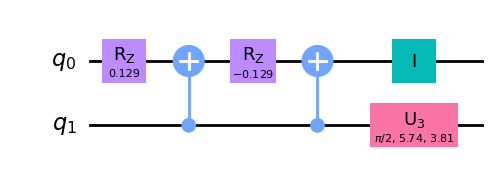

In [1]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
display(circuit.draw("mpl"))

2. At least one observable to measure. Observables represent physical properties of a quantum system (e.g. energy, spin), and allow said properties to be measured (e.g. their expectation values) for a given state of our system. For simplicity, you can use the [PauliSumOp class](https://qiskit.org/documentation/stubs/qiskit.opflow.primitive_ops.html#module-qiskit.opflow.primitive_ops) in Qiskit to define them, as illustrated in the example below.

In [2]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("XZ")
print(f"  > Observable: {observable.paulis}")

  > Observable: ['XZ']


3. An instance of any `Estimator` class complying with the _Estimator_ primitive specification. For simplicity, we will use Qiskit Terra's `qiskit.primitives.Estimator` class, based on the [`Statevector` construct](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html?highlight=statevector#qiskit.quantum_info.Statevector) (i.e. algebraic simulation).

In [3]:
from qiskit.primitives import Estimator

estimator = Estimator()

### Run a single experiment
You can invoke the _Estimator_ primitive program using the `run()` method of the `Estimator` instance you just created. The method returns a `JobV1` object which you can use to query for things like `job_id()` and `status()`.

In [4]:
job = estimator.run(circuit, observable)
print(f">>> {job.job_id()}")
print(f">>> {job.status()}")

>>> a8987737-29b2-4f4b-ba11-4b3104360192
>>> JobStatus.DONE


The `result()` method of the job will return the `EstimatorResult`.

In [5]:
result = job.result()
print(f">>> {result}")

>>> EstimatorResult(values=array([0.85347811]), metadata=[{}])


Finally, to extract different information about the result:

In [6]:
expval = result.values[0]
metadatum = result.metadata[0]

print(f"  > Expectation value: {expval}")
print(f"  > Metadata: {metadatum}")

  > Expectation value: 0.8534781134132173
  > Metadata: {}


You can keep invoking the `run()` method again with the different inputs:

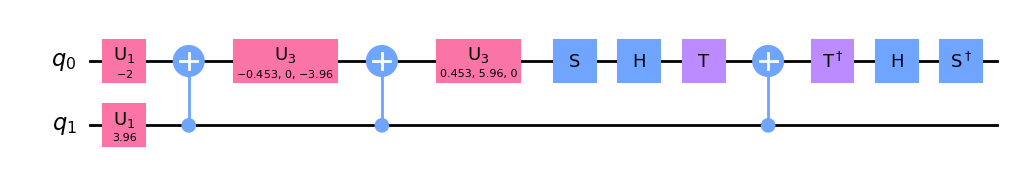

  > Observable: ['IY']
  > Expectation value: -1.582539029327245e-16
  > Metadata: {}


In [7]:
circuit = random_circuit(2, 2, seed=1).decompose(reps=1)
observable = SparsePauliOp("IY")

job = estimator.run(circuit, observable)
result = job.result()

display(circuit.draw("mpl"))
print(f"  > Observable: {observable.paulis}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

### Run multiple experiments (batching)
You can also prove compound inputs to the `run()` method in order to execute multiple experiments sequentially:

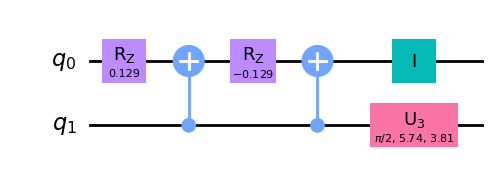

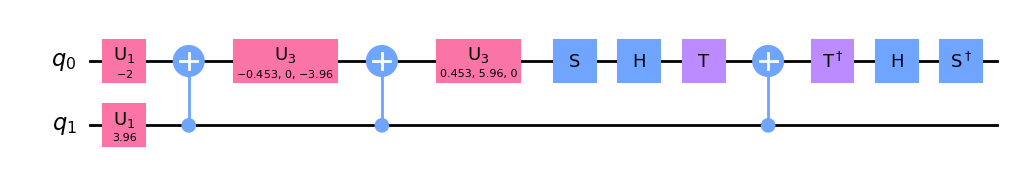

  > Observables: [PauliList(['XZ']), PauliList(['IY'])]
  > Expectation values: [0.8534781134132173, -1.582539029327245e-16]
  > Metadata: [{}, {}]


In [8]:
circuits = (
    random_circuit(2, 2, seed=0).decompose(reps=1),
    random_circuit(2, 2, seed=1).decompose(reps=1),
)
observables = (
    SparsePauliOp("XZ"),
    SparsePauliOp("IY"),
)

job = estimator.run(circuits, observables)
result = job.result()

[display(cir.draw("mpl")) for cir in circuits]
print(f"  > Observables: {[obs.paulis for obs in observables]}")
print(f"  > Expectation values: {result.values.tolist()}")
print(f"  > Metadata: {result.metadata}")

### Run multiple experiments (asynchronous)
Creating multiple jobs will run the experiments in parallel:

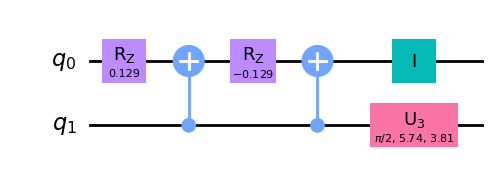

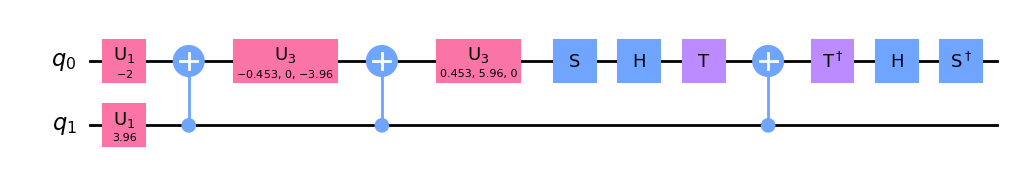

  > Observables: [PauliList(['XZ']), PauliList(['IY'])]
  > Expectation values [0]: 0.8534781134132173
  > Metadata [0]: {}
  > Expectation values [1]: -1.582539029327245e-16
  > Metadata [1]: {}


In [9]:
circuits = (
    random_circuit(2, 2, seed=0).decompose(reps=1),
    random_circuit(2, 2, seed=1).decompose(reps=1),
)
observables = (
    SparsePauliOp("XZ"),
    SparsePauliOp("IY"),
)

job_0 = estimator.run(circuits[0], observables[0])
job_1 = estimator.run(circuits[1], observables[1])

result_0 = job_0.result()
result_1 = job_1.result()

[display(cir.draw("mpl")) for cir in circuits]
print(f"  > Observables: {[obs.paulis for obs in observables]}") 
print(f"  > Expectation values [0]: {result_0.values.tolist()[0]}") 
print(f"  > Metadata [0]: {result_0.metadata[0]}")
print(f"  > Expectation values [1]: {result_1.values.tolist()[0]}") 
print(f"  > Metadata [1]: {result_1.metadata[0]}")

### Parametrized states
Many real world applications of quantum computers depend on preparing quantum states according to certain parametrization or _ansatz_. The _Estimator_ primitive offers support for these scenarios by accepting parametrized circuits as inputs, along with one extra argument to bind them: `parameter_values`.

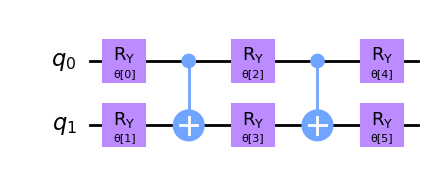

  > Observable: ['ZI']
  > Parameter values: [0, 1, 2, 3, 4, 5]
  > Expectation value: -0.6485568434766461
  > Metadata: {}


In [10]:
from qiskit.circuit.library import RealAmplitudes

circuit = RealAmplitudes(num_qubits=2, reps=2).decompose(reps=1)
observable = SparsePauliOp("ZI")
parameter_values = [0, 1, 2, 3, 4, 5]

job = estimator.run(circuit, observable, parameter_values)
result = job.result()

display(circuit.draw("mpl"))
print(f"  > Observable: {observable.paulis}")
print(f"  > Parameter values: {parameter_values}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

### Configuration and options
On top of this basic usage, `Estimator` classes can also support custom configuration through two kinds of options:
1. Instance level options which serve as defaults.
2. Run options to update defaults for a single job.

The particular `Estimator` that we have been using so far accepts a `shots` option to fabricate a random sampling which mimics the process that usually takes place in real hardware. This will result in a non-exact, statistical, result, with the corresponding variance reported along in the metadata.

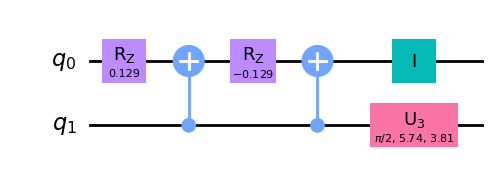

  > Observable: ['XZ']
  > Expectation value: 0.8584743310229327
  > Metadata: {'variance': 0.2715751099246151, 'shots': 2048}


In [11]:
estimator = Estimator(options={"shots": 2048})  # Defaults !!!

circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
observable = SparsePauliOp("XZ")

job = estimator.run(circuit, observable)
result = job.result()

display(circuit.draw("mpl"))
print(f"  > Observable: {observable.paulis}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

And we can override the default `shots` when calling `run()`:

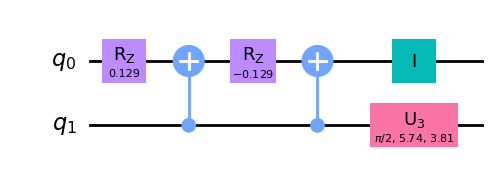

  > Observable: ['XZ']
  > Expectation value: 0.8594588994433835
  > Metadata: {'variance': 0.2715751099246151, 'shots': 1024}


In [12]:
circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
observable = SparsePauliOp("XZ")

job = estimator.run(circuit, observable, shots=1024)  # Job-only !!!
result = job.result()

display(circuit.draw("mpl"))
print(f"  > Observable: {observable.paulis}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

## Getting started with Estimator on the runtime service 

Follow the steps in the [getting started guide](../getting_started.rst) to get your quantum service instance ready to use.

## Start a session

A Qiskit Runtime session allows you to group a collection of iterative calls to the timeshare quantum computer. A session is started when the first job of the program is dequeued. Subsequent jobs within the session are prioritized by the scheduler to minimize artificial delay within an iterative algorithm. Data used within a session, such as transpiled circuits, is also cached to avoid unnecessary overhead. You can create a Runtime session using the context manager `(with ...:)`, which automatically opens and closes the session for you.

    with Session(service) as session:
        estimator = Estimator(session=session, options=options) #primitive constructor
	     estimator.run(circuit, parameters, observable) #job call

### Create an Estimator instance

You can make one or more calls to the _Estimator_ primitive within a session, by first creating an _Estimator_ instance. The _Estimator_ class takes in an _options_ variable to control the execution environment.

The _options_ can be either a dictionary or a _qiskit_ibm_runtime.Options_ class instance. Initializing it as an _Options_ class allows you to use auto complete.

Some of the settings you can specify using options:

* optimization_level: How much optimization to perform on the circuits. The default is 3.

* resilience_level: How much resilience to build against errors. Higher levels generate more accurate results, at the expense of longer processing times. The default is 1.

You can find full details in the [Options API reference](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.options.Options.html#qiskit_ibm_runtime.options.Options).

With these arguments, you can create an _Estimator_ instance with the desired options. 

#### Example:

    

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options

service = QiskitRuntimeService()
options = Options(optimization_level=3)

with Session(service=service, backend="ibmq_qasm_simulator"):
     estimator = Estimator(options=options)